# Numeric posterior of the independent variable
In this notebook, we demonstrate the use of *infer_independent* and *predict_independent*. Given observations $Y_{obs}$ made at the same corresponding independent variable (e.g. several slightly different measurements of the same glucose concentration), *infer_independent* will return a probability distribution taking all observations into account. *predict_independent* will only return the median of a distribution under the assumption that this was the only observation. For a uniform prior, the posterior inferred by MCMC yields the same result as a numerically integrated likelihood function, which is demonstrated at the end of the notebook.

In [1]:
import ipywidgets
from matplotlib import pyplot
import numpy
import pymc3 as pm
import scipy.optimize
import scipy.stats


import calibr8

## Synthetic groundtruth

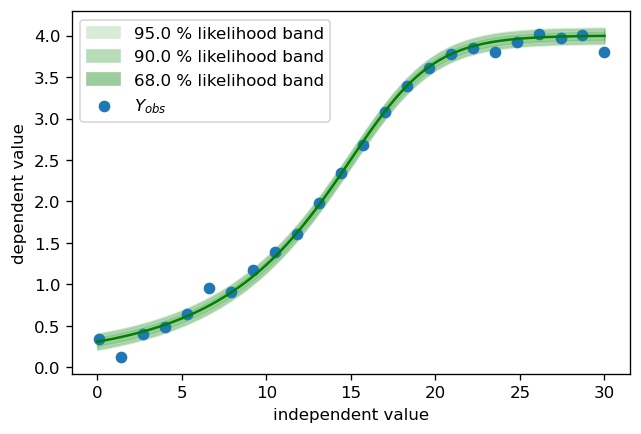

In [2]:
θ_true = (0.1, 4, 15, 0.3, 1)
σ_true = 0.05
df_true = 1.5
X = numpy.linspace(0.1, 30, 24)
X_dense = numpy.linspace(0, 30, 100)
Y = calibr8.asymmetric_logistic(X, θ_true)
numpy.random.seed(230620)
Y = scipy.stats.t.rvs(loc=Y, scale=σ_true, df=df_true)

fig, ax = pyplot.subplots(dpi=120)

calibr8.plot_norm_band(ax, X_dense, calibr8.asymmetric_logistic(X_dense, θ_true), σ_true)

ax.scatter(X, Y, label='$Y_{obs}$')

ax.set_xlabel('independent value')
ax.set_ylabel('dependent value')
ax.legend()
pyplot.show()

## Model definition

In [3]:
class AsymmetricTModelV1(calibr8.BaseAsymmetricLogisticT):
    def __init__(self):
        super().__init__(independent_key='independent', dependent_key='dependent', scale_degree=0)

## Model fit

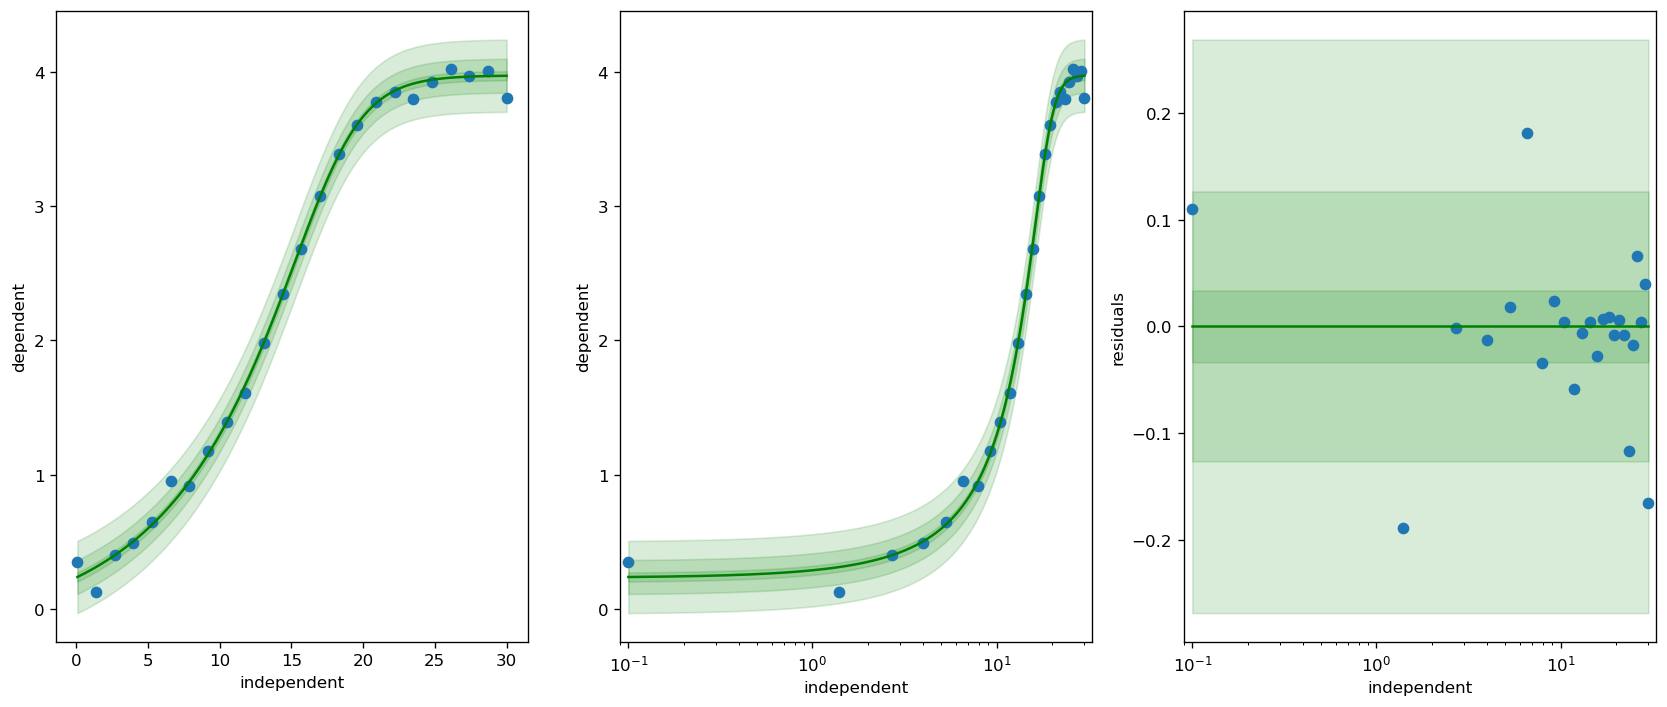

The following estimations were made for ('L_L', 'L_U', 'I_x', 'S', 'c', 'scale_0', 'df'): (-0.16186415430275183, 3.974968429712193, 15.262598606879964, 0.2865868063157404, 1.3554374028494678, 0.017449324854292902, 0.925104868448804)


In [4]:
model = AsymmetricTModelV1()
calibr8.fit_scipy(
    model,
    independent=X, dependent=Y,
    theta_guess=[
        0,   # lower limit approximately at 0 ?
        4.5, # upper limit maybe around 4.5 ?
        12,  # inflection point maybe at arond 12 ?
        1/5, # approximate slope at inflection point
        2,   # asymmetry paramter: the inflection point is near the upper limit -> positive value
    ] + [0.01, 5],
    theta_bounds=[
        (-numpy.inf, 1),   # L_L
        (3.5, numpy.inf),  # L_U
        (10, 20),          # I_x
        (1/20, 1),         # S
        (-3, 3),           # c
    ] + [(0.01, 0.5), (0.5, 50)]
)

fig, axs = calibr8.plot_model(model)
fig.tight_layout()
pyplot.show()
print(f'The following estimations were made for {model.theta_names}: {model.theta_fitted}')

## Visualization

In [5]:
def plot(y_obs=0.5, a=0, b=30, steps=1000, ci_prob=0.95):
    y_obs = numpy.atleast_1d(y_obs)
    fig, ax = pyplot.subplots(dpi=120)
    
    posterior = model.infer_independent(y_obs, lower=a, upper=b, steps=steps, ci_prob=ci_prob)
    ax.plot(posterior.hdi_x, posterior.hdi_pdf, color='b')
    
    # Plot the individual predictions from predict_independent for comparison
    for yo in y_obs:
        ax.axvline(model.predict_independent(yo), linestyle='--', color='b', alpha=0.3)
    ax.plot([], linestyle='--', label='predict_independent', color='b', alpha=0.3) #to get only one legend
    
    # For multiple observations of the same independent variable, 
    # the median of the posterior will differ from the two predict_independent results
    ax.annotate('median', xy=(posterior.median, 0),
        xytext=(posterior.median, numpy.max(posterior.hdi_pdf)*0.2), xycoords='data',
        arrowprops=dict(facecolor='b', edgecolor='b', shrink=0.05),
        horizontalalignment='right', verticalalignment='top', 
        ha='center'
    )
    
    ax.legend()
    ax.set_xlabel('independent variable')
    ax.set_ylabel(r'$p(x\ |\ \vec{y}_{obs})$')
    ax.set_ylim(0)
    return fig, ax

## Plot for one observation, where predict_independent is similar to the median

In [6]:
def iplot(y_obs=0.5, a=0, b=30, steps=1000, ci_prob=0.95):
    plot(y_obs, a, b, steps, ci_prob)
    pyplot.show()

ipywidgets.interact(
    iplot,
    y_obs=θ_true[0:2],
    a=ipywidgets.fixed(0),
    b=ipywidgets.fixed(30), 
    steps=ipywidgets.fixed(1000),
    percentiles=ipywidgets.fixed((0.025, 0.975))
);

interactive(children=(FloatSlider(value=0.5, description='y_obs', max=4.0, min=0.1), FloatSlider(value=0.95, d…

## Comparison with MCMC for two observations

In [7]:
y_obs = numpy.array([3.85,3.9])
a = 0
b = 30

theta = model.theta_fitted
with pm.Model():
    prior = pm.Uniform(model.independent_key, lower=a, upper=b, shape=(1,))
    mu, scale, df = model.predict_dependent(prior, theta=theta)
    pm.StudentT('likelihood', nu=df, mu=mu, sigma=scale, observed=y_obs, shape=(1,))
    idata = pm.sample(10_000, cores=1, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [independent]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.9673179083347845, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


Here we can see how the median differs from *predict_independent* results

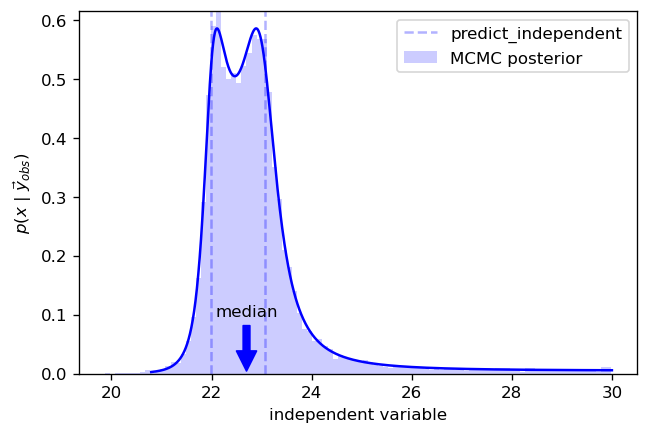

In [8]:
fig, ax = plot(y_obs=y_obs, ci_prob=0.999)
ax.hist(
    idata.posterior['independent'].stack(sample=('chain', 'draw')).values.T,
    density=True, bins=100, color="b", alpha=0.2,
    label='MCMC posterior'
)
ax.legend()
pyplot.show()

In [9]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Feb 22 2021

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.19.0

matplotlib: 3.3.2
calibr8   : 6.0.0
numpy     : 1.19.2
pymc3     : 3.11.1
ipywidgets: 7.6.3
scipy     : 1.5.2

Watermark: 2.1.0

